In [5]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding,GRU,TimeDistributed,RepeatVector,Merge,BatchNormalization
from keras.preprocessing import sequence
from keras import callbacks
from keras.optimizers import SGD, RMSprop, Adam
import numpy as np
from vgg16 import Vgg16
import matplotlib.pyplot as plt
import PIL.Image

from tqdm import tqdm

from utils import *

import cPickle as pickle
import string

import collections
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import re
from numpy.random import random, permutation, randn, normal 

import os

import preprocessing as preproc


In [42]:

def constructImageEntryArr(imageDataArr):
    image_entry_arr = []

    for imageData in imageDataArr:
        image = imageData.image

        for caption in imageData.captions:
            image_entry_arr.append(ImageEntry(image,caption))

    return image_entry_arr


def get_unique_words(captions):
    unique_words = []
    words = [caption.split() for caption in captions]
   
    for word in words:
        unique_words.extend(word)
        
    unique_words = list(set(unique_words))
    
    return unique_words

def get_index_word_dicts(unique_words):
    word_index = {}
    index_word = {}
    for i,word in enumerate(unique_words):
        word_index[word] = i
        index_word[i] = word
        
    return (word_index,index_word)

def get_train_captions_indexed(captions, word2index, MAX_CAPTION_LEN ):
    
    train_captions_indexed = []
    for caption in captions:
        one = [word2index[caption_word] for caption_word in caption.split()]
        train_captions_indexed.append(one)

    train_captions_indexed = sequence.pad_sequences(train_captions_indexed, maxlen=MAX_CAPTION_LEN,padding='post')
    return train_captions_indexed

        
        
def compute_partial_all_words_2_next_word(captions_indexed,step_size,temp_save_path):
    
    if not os.path.exists(temp_save_path):
        os.makedirs(temp_save_path)
    
    for window_start in tqdm(range(0,len(captions_indexed),step_size)):
    
        captions_indexed_batch = captions_indexed[window_start:window_start+step_size]

        all_words_2_next_word = []

        for caption_indexed in captions_indexed_batch:

            word_2_next_word = []

            enhanced_caption_indexed = np.append(caption_indexed,[word2index["END"]]) #hacky

            for i in xrange(0,len(caption_indexed)):
                caption_word_index = enhanced_caption_indexed[i]
                future_word_index = enhanced_caption_indexed[i+1]
                future_indexes = np.zeros(VOCAB_SIZE)
                future_indexes[future_word_index] = 1

                word_2_next_word.append(future_indexes)

            words_2_next_word = np.vstack(word_2_next_word)

            all_words_2_next_word.append(words_2_next_word)

        save_array(temp_save_path+ 'all_words_2_next_word__'+str(format(window_start, "06"))+'.bc', all_words_2_next_word)
    
def get_future_words(temp_save_path):
    all_words_2_next_word_paths= [f for f in listdir(temp_save_path)]
    all_words_2_next_word_paths.sort()

    all_words_2_next_word = [load_array(temp_save_path + all_words_2_next_word_path) 
                             for all_words_2_next_word_path in all_words_2_next_word_paths ]

    future_words = np.vstack(all_words_2_next_word)
    future_words = np.transpose(future_words,(0,1,2))
    
    return future_words
    
def load_vectors(loc):
    return (load_array(loc+'.dat'),
        pickle.load(open(loc+'_words.pkl','rb')),
        pickle.load(open(loc+'_idx.pkl','rb')))

def create_emb(vecs,words,wordidx,vocab_size):
    n_fact = vecs.shape[1]
    emb = np.zeros((vocab_size, n_fact))

    found = 0
    not_found = 0
    
    exclude = set(string.punctuation)
    for i in range(1,len(emb)):
        word = index2word[i]
        word = ''.join(ch for ch in word if ch not in exclude).lower()
        if word and re.match(r"^[a-zA-Z0-9\-]*$", word) and word in wordidx:
            src_idx = wordidx[word]
            emb[i] = vecs[src_idx]
            found +=1
        else:
            # If we can't find the word in glove, randomly initialize
            emb[i] = normal(scale=0.6, size=(n_fact,))
            not_found+=1
#             print(word)

    # This is our "rare word" id - we want to randomly initialize
    emb[-1] = normal(scale=0.6, size=(n_fact,))
    emb/=3
    
    print("Found = %d"%found)
    print("Not found = %d"%not_found)
        
    return emb

    

def search_images_by(searched_word,images,predicted_captions):
    lmtzr = WordNetLemmatizer()
    lemm_word = lmtzr.lemmatize(searched_word)
    
    found_indexes = []
    for index,caption in enumerate(predicted_captions):
        lemm_caption_words = [lmtzr.lemmatize(word) for word in caption.split()]
        if lemm_word in lemm_caption_words:
            found_indexes.append(index)
    
    return ([images[i] for i in found_indexes],[predicted_captions[i] for i in found_indexes])

def get_test_model(model):
    test_model = Sequential()
    test_model.add(Merge([vgg_model, language_model], mode='concat'))
    for layer in model.layers[1:]:
        test_model.add(layer)
        
    test_model.compile(loss='categorical_crossentropy', optimizer = Adam(0.001))
    return test_model

def plot_predictions(ims, titles = None):  
    for i in range(len(ims)):
        if(titles):
            plt.title(titles[i])
        plt.imshow(ims[i])
        plt.figure()
            
    plt.show()
    
def make_prediction(random_number,images_concat_t,vgg_model):
    startIndex = word2index["START"]
    start_captions = [[startIndex]]
    start_captions = sequence.pad_sequences(start_captions, maxlen=MAX_CAPTION_LEN,padding='post')

    firstImage = np.expand_dims(images_concat_t[random_number], axis=0)

    first_image_vgg_features = vgg_model.predict(firstImage)
#     first_image_input = firstImage
    first_image_input = np.squeeze(first_image_vgg_features)[0].reshape(1,4096)
    
    firstCaption = np.expand_dims(start_captions[0], axis=0) 

    outputs = []

    endGenerated = False
    i = 0
    while ((not endGenerated) & (i < MAX_CAPTION_LEN-1)):

        predictions = model.predict([first_image_input, firstCaption])
        predictions = predictions[0]

        currentPred = predictions[i]

        max_index = np.argmax(currentPred)

        outputs.append(max_index)
        firstCaption[0,i+1] = max_index

        i+=1

        if(index2word[max_index] == "END"):
            endGenerated = True

    caption = ' '.join([index2word[x] for x in firstCaption[0][:i+1]]) 
    
    drawImage = firstImage[0]
    drawImageT = np.transpose(drawImage,(1,2,0))
    plt.imshow(drawImageT)
    
    return (drawImageT,caption)

def make_prediction_on_dataset(images_concat_t, window_start = None, no_images = None):
    
    if(window_start == None):
        window_start = 0
        
    if(no_images == None):
        no_images = len(images_concat_t)
    
    vgg_model = get_vgg_model()
    
    images2Captions = [make_prediction(i,images_concat_t,vgg_model) for i in tqdm(range(window_start,window_start+no_images))]
    images = [image2Caption[0] for image2Caption in images2Captions]
    predicted_captions = [image2Caption[1] for image2Caption in images2Captions]

    
    return (images,predicted_captions)
    
def generate_arrays_from_file(img_vgg_path,indexed_captions_path,future_words_path):
    while 1:
        img_vgg_elements = os.listdir(img_vgg_path)
        indexed_captions_elements = os.listdir(indexed_captions_path)
        future_words_elements = os.listdir(future_words_path)
        
        img_vgg_elements.sort()
        indexed_captions_elements.sort()
        future_words_elements.sort()

        nr_elem = len(img_vgg_elements)
        
        BATCH_SIZE = 1
        
        for index in range(nr_elem/BATCH_SIZE):
            
            img_vgg_batch_list = []
            indexed_caption_batch_list = []
            future_words_batch_list = []
            
            for elem_in_batch in range(BATCH_SIZE):
                
                img_vgg_el_name = img_vgg_elements[index*BATCH_SIZE + elem_in_batch]
                indexed_caption_name = indexed_captions_elements[index*BATCH_SIZE + elem_in_batch]
                future_words_el_name = future_words_elements[index*BATCH_SIZE + elem_in_batch]

                img_vgg = preproc.load_array(img_vgg_path+"/"+img_vgg_el_name)
                indexed_caption = preproc.load_array(indexed_captions_path+"/"+indexed_caption_name)
                future_words = preproc.load_array(future_words_path+"/"+future_words_el_name)
                
                img_vgg_batch_list.append(img_vgg)
                indexed_caption_batch_list.append(indexed_caption)
                future_words_batch_list.append(future_words)
                
            img_vgg_big = np.vstack(img_vgg_batch_list)
            indexed_caption_big = np.vstack(indexed_caption_batch_list)
            future_words_big = np.vstack(future_words_batch_list)
            
#             print(img_vgg_big.shape)
#             print(indexed_caption_big.shape)
#             print(future_words_big.shape)
    
            yield ([img_vgg_big,indexed_caption_big], future_words_big)

def get_test_data(img_vgg_path,indexed_captions_path,future_words_path):
    img_vgg_elements = os.listdir(img_vgg_path)
    indexed_captions_elements = os.listdir(indexed_captions_path)
    future_words_elements = os.listdir(future_words_path)

    img_vgg_elements.sort()
    indexed_captions_elements.sort()
    future_words_elements.sort()

    nr_batches = 1

    for index in tqdm(range(nr_batches)):

        img_vgg_batch_list = []
        indexed_caption_batch_list = []
        future_words_batch_list = []

        img_vgg_el_name = img_vgg_elements[index]
        indexed_caption_name = indexed_captions_elements[index]
        future_words_el_name = future_words_elements[index]

        img_vgg = preproc.load_array(img_vgg_path+"/"+img_vgg_el_name)
        indexed_caption = preproc.load_array(indexed_captions_path+"/"+indexed_caption_name)
        future_words = preproc.load_array(future_words_path+"/"+future_words_el_name)

        img_vgg_batch_list.append(img_vgg)
        indexed_caption_batch_list.append(indexed_caption)
        future_words_batch_list.append(future_words)

    img_vgg_big = np.vstack(img_vgg_batch_list)
    indexed_caption_big = np.vstack(indexed_caption_batch_list)
    future_words_big = np.vstack(future_words_batch_list)

    print(img_vgg_big.shape)
    print(indexed_caption_big.shape)
    print(future_words_big.shape)

    return img_vgg_big, indexed_caption_big, future_words_big
      
        

In [7]:
base_path = app_3_length_15_data_path

train_path = base_path + train_folder
val_path = base_path + val_folder

# Read Serialized Data - Images

In [15]:
test_images_concat_t = preproc.get_images_concat(val_path + images_concat_folder+ 'images_concat.bc',1000)
print(test_images_concat_t.shape)

(1000, 3, 224, 224)


# Load precomputed misc data structures

In [22]:
base_path = app_3_length_15_data_path

train_img_vgg_path = base_path + train_folder + batch_folder + images_vgg_4096_folder
train_indexed_captions_path = base_path + train_folder + batch_folder + indexed_captions_folder
train_raw_captions_path = base_path + train_folder + batch_folder + captions_folder
train_future_words_path = base_path + train_folder + batch_folder + indexed_future_words_folder

test_img_vgg_path = base_path + val_folder + batch_folder +images_vgg_4096_folder
test_indexed_captions_path = base_path + val_folder + batch_folder + indexed_captions_folder
test_raw_captions_path = base_path + val_folder + batch_folder+captions_folder
test_future_words_path = base_path + val_folder + batch_folder+indexed_future_words_folder



In [27]:
reload(preproc)

<module 'preprocessing' from 'preprocessing.py'>

In [28]:
unique_words = preproc.load_obj(base_path + general_datastruct_folder+"unique_words")
word2index = preproc.load_obj(base_path+general_datastruct_folder+"word2index")
index2word = preproc.load_obj(base_path+general_datastruct_folder+"index2word")

(train_captions_raw,_) = preproc.get_captions_raw_and_indexed(train_raw_captions_path,train_indexed_captions_path)
(test_captions_raw,_) = preproc.get_captions_raw_and_indexed(test_raw_captions_path,test_indexed_captions_path)


100%|██████████| 14/14 [00:00<00:00, 680.57it/s]


In [31]:
VOCAB_SIZE = len(unique_words)
MAX_CAPTION_LEN = 15 # ATENTIE AICI

In [32]:
print("MAX_CAPTION_LEN = %s"%MAX_CAPTION_LEN)
print("VOCAB_SIZE = %s"%VOCAB_SIZE)


MAX_CAPTION_LEN = 15
VOCAB_SIZE = 7275


# Word Embeddings

In [33]:
EMB_SIZE = 200
vecs, words, wordidx = load_vectors(save_path+glove_folder+"6B."+str(EMB_SIZE)+"d")

emb = create_emb(vecs, words, wordidx,VOCAB_SIZE)

Found = 7025
Not found = 249


# Model Building

In [34]:
# VGG
def get_vgg_model():
    image_model = Vgg16().model
    image_model.pop()
    image_model.pop()
    image_model.trainable = False
    image_model.add(RepeatVector(MAX_CAPTION_LEN))
    return image_model

def get_precomputed_input_model():
    input_model = Sequential()
    input_model.add(RepeatVector(MAX_CAPTION_LEN,input_shape=(4096,)))
    return input_model


# GRU
def get_language_model(emb):
    language_model = Sequential()
    #language_model.add(Embedding(VOCAB_SIZE, 256, input_length=MAX_CAPTION_LEN))
    #language_model.add(Embedding(VOCAB_SIZE, EMB_SIZE, input_length=MAX_CAPTION_LEN,weights=[emb], trainable=False))
    language_model.add(Embedding(VOCAB_SIZE, EMB_SIZE, input_length=MAX_CAPTION_LEN,weights=[emb]))
    Dropout(0.2)
    language_model.add(BatchNormalization())
    return language_model


# Top level model
def build_model(image_model,language_model):
    model = Sequential()
    model.add(Merge([image_model, language_model], mode='concat'))
    model.add(GRU(1024, return_sequences=True))
    model.add(TimeDistributed(Dense(VOCAB_SIZE, activation = 'softmax')))

    model.compile(loss='categorical_crossentropy', optimizer = Adam(0.001))
    return model


In [35]:
image_model = get_precomputed_input_model()
language_model = get_language_model(emb)
model = build_model(image_model,language_model)

# Training the model

In [37]:
test_img_vgg, test_indexed_captions, test_future_words = get_test_data(test_img_vgg_path,
                                                                       test_indexed_captions_path,
                                                                       test_future_words_path)

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


(2048, 4096)
(2048, 15)
(2048, 15, 7275)


In [ ]:
history = model.fit_generator(
                    generate_arrays_from_file(train_img_vgg_path,train_indexed_captions_path,train_future_words_path),
                    samples_per_epoch=2000,
                    nb_epoch=3,
                    validation_data = ([test_img_vgg, test_indexed_captions], test_future_words),
                    callbacks=[callbacks.RemoteMonitor()]
                   )

In [ ]:
preproc.plot_loss_from_history(history)

In [ ]:
model.evaluate_generator(generate_arrays_from_file(test_img_vgg_path,test_indexed_captions_path,test_future_words_path),
                         val_samples = 2048)

In [ ]:
# model.save_weights(save_path + models_folder +'app_3_length_15_30_epoch.h5')

In [38]:
model.load_weights(save_path + models_folder +'app_3_length_15_30_epoch.h5')

# Testing the model

In [46]:
window_start = 0
nr_images = 8


# images_concat_t = train_images_concat_t
# real_captions = train_captions_raw

images_concat_t = test_images_concat_t
real_captions = test_captions_raw

(images,predicted_captions) = make_prediction_on_dataset(images_concat_t,window_start,nr_images)


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


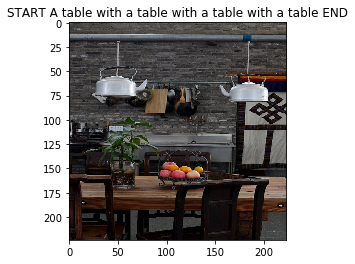

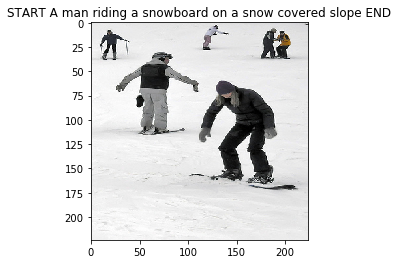

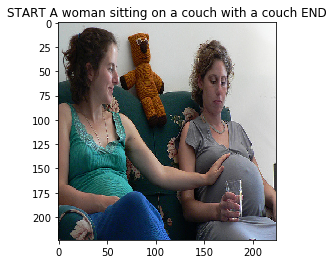

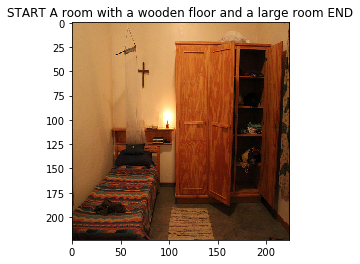

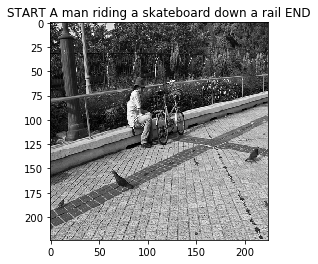

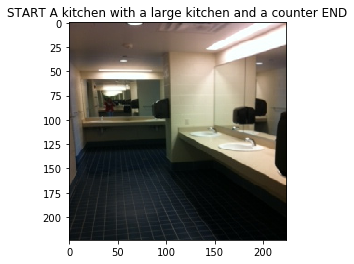

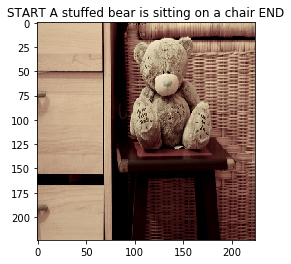

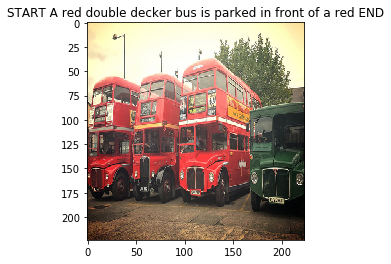

In [47]:
plot_predictions(images,titles = predicted_captions)

In [ ]:
def bleu_score_metric(reality, prediction):
    return nltk.translate.bleu_score.sentence_bleu([reality], prediction)

def compute_bleu_score_metric(predicted_captions, real_captions):
    real_captions = reduce(list.__add__, [list(real_caption) for real_caption in real_captions])
    bleu_scores = [bleu_score_metric(real_captions[i], predicted_captions[i]) for i in range(len(predicted_captions))]
    return np.average(bleu_scores)

def most_common_words(captions,word_limit):
    
    sentences = [caption.split() for caption in captions]
    words = []
    for word in sentences:
        words.extend(word)

    counter=collections.Counter(words)
    return counter.most_common(word_limit)



In [ ]:
compute_bleu_score_metric(predicted_captions, real_captions)

In [ ]:
common_words2app = most_common_words(predicted_captions,500)
common_words2app = [(word,app) for word,app in common_words2app if word.lower() not in stopwords.words('english')]
common_words2app = [(word,app) for word,app in common_words2app if word not in ['START','END']]


In [ ]:
common_words2app

In [ ]:
searched_word = "teeth"
(found_images,found_captions) = search_images_by(searched_word,images,predicted_captions)
print("Number of results = %d"%len(found_images))

In [ ]:
plot_predictions(found_images,found_captions)

# Make predictions on misc dataset

In [43]:
misc_images_path = save_path + misc_images_folder

In [44]:
misc_images = []
for img_path in os.listdir(misc_images_path):
    img = PIL.Image.open(misc_images_path+img_path)
    img = img.resize((224, 224), PIL.Image.NEAREST)
    img = np.asarray(img)
    img = np.transpose(img,(2,0,1))
    img = np.expand_dims(img,axis=0)
    
    misc_images.append(img)
    
stacked_images = np.vstack(misc_images)

100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


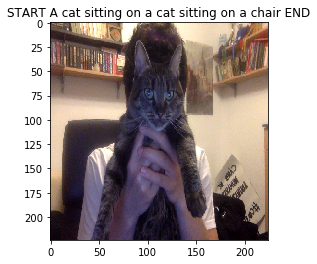

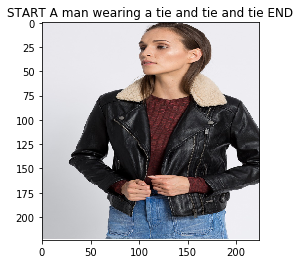

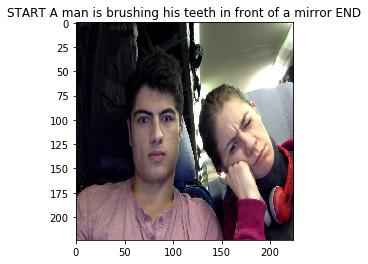

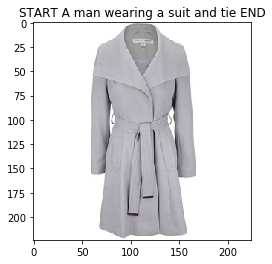

In [45]:
(misc_images,misc_predicted_captions) = make_prediction_on_dataset(stacked_images)
plot_predictions(misc_images,misc_predicted_captions)